# Normailty Check of Cyclic Voltammetry Measurements:

## Intitialization

In [1]:
import os
import time
import Pyro4
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt


from globus_compute_sdk import Executor
from globus_compute_sdk import Client
gcc= Client() 

## Compute services I-V Profile Fitting & Classification over Globus endpoints

### Feature Extraction: Compute V-Probe

In [2]:
# on Polaris
usr_path="/home/aneesalnajjar/.globus_compute/ornl_polaris_ep2"
ornl_endpoint_polaris_id='06990509-6363-4879-9fa8-a1d7e933093d'

sys_path_polaris=f"{usr_path}/acl_dependencies"
training_data_path_polaris=f"{usr_path}/acl_dependencies/training_profiles"
EoT_Classifier_Path_polaris=f"{usr_path}/acl_dependencies/ml_models_dir"

# module use /soft/modulefiles; module load conda ; conda activate base
# conda activate ornl_polaris_venv
# globus-compute-endpoint list
# globus-compute-endpoint restart ornl_polaris_ep2


sys_path_ep=sys_path_polaris
ornl_endpoint_id=ornl_endpoint_polaris_id
training_data_path_ep=training_data_path_polaris
EoT_Classifier_Path_ep=EoT_Classifier_Path_polaris

In [3]:
def compute_v_probe(sys_path):
    import os, sys
    sys.path.append(sys_path)
    print(sys.path)
    import workflow_config
    v_p= workflow_config.v_probe
    return v_p
# ... then create the executor, ...
with Executor(endpoint_id=ornl_endpoint_id,amqp_port=443) as gce:
    # ... then submit for execution, ...
    future = gce.submit(compute_v_probe,sys_path_ep)
    v_probe=future.result()

#     # ... and finally, wait for the result
   #print(future.result())
#print(gcc.get_endpoint_status(ornl_endpoint_id))

Warning - dependency versions are mismatched between local SDK and remote worker on endpoint 06990509-6363-4879-9fa8-a1d7e933093d: local SDK uses Python 3.10.9/Dill 0.3.5.1 but worker used 3.10.14/0.3.5.1
(worker SDK version: 2.26.0; worker OS: Linux-5.14.21-150500.55.49-default-x86_64-with-glibc2.31)


### Feature Extraction: Compute I-Probe using GPR

In [4]:
# Learn the model and preform feature extraction
def compute_i_probe(v_probe,sys_path,training_data_path):
    import os, sys
    sys.path.append(sys_path)
    save_file_flag=False
    show_IV_plot=False
    from ml_models_for_normality_check import GPR_for_CV_feature_extraction
    i_p=GPR_for_CV_feature_extraction(training_data_path,v_probe)
    return i_p
# ... then create the executor, ...
with Executor(endpoint_id=ornl_endpoint_id,amqp_port=443) as gce:
    # ... then submit for execution, ...
    future = gce.submit(compute_i_probe,v_probe,sys_path_ep,training_data_path_ep)
    i_probe=future.result()

Warning - dependency versions are mismatched between local SDK and remote worker on endpoint 06990509-6363-4879-9fa8-a1d7e933093d: local SDK uses Python 3.10.9/Dill 0.3.5.1 but worker used 3.10.14/0.3.5.1
(worker SDK version: 2.26.0; worker OS: Linux-5.14.21-150500.55.49-default-x86_64-with-glibc2.31)


### IV Class Labling

In [5]:
# Assign Classes to the training data set

def assign_class(i_p,sys_path):
    import os, sys
    sys.path.append(sys_path)
    from ml_models_for_normality_check import call_assign_classes
    i_p=call_assign_classes(i_p)
    return i_p
# ... then create the executor, ...
with Executor(endpoint_id=ornl_endpoint_id,amqp_port=443) as gce:
    # ... then submit for execution, ...
    future = gce.submit(assign_class,i_probe,sys_path_ep)
    i_probe=future.result()


Warning - dependency versions are mismatched between local SDK and remote worker on endpoint 06990509-6363-4879-9fa8-a1d7e933093d: local SDK uses Python 3.10.9/Dill 0.3.5.1 but worker used 3.10.14/0.3.5.1
(worker SDK version: 2.26.0; worker OS: Linux-5.14.21-150500.55.49-default-x86_64-with-glibc2.31)


### Train EOT Classifier

In [6]:
# Train a classifer with the probing measurement

def train_EoT_classifier(i_p,sys_path,EoT_Classifier_Path):
    import os, sys
    sys.path.append(sys_path)
    EoT_Classifier = "clf.pckl"
    from ml_models_for_normality_check import call_Train_n_Serialize_RF_Classifier
    x=call_Train_n_Serialize_RF_Classifier(i_p,EoT_Classifier_Path, EoT_Classifier)
    return x
    
    
# ... then create the executor, ...
with Executor(endpoint_id=ornl_endpoint_id,amqp_port=443) as gce:
# ... then submit for execution, ...
    x=gce.submit(train_EoT_classifier,i_probe,sys_path_ep,EoT_Classifier_Path_ep)
    print(x.result())



Warning - dependency versions are mismatched between local SDK and remote worker on endpoint 06990509-6363-4879-9fa8-a1d7e933093d: local SDK uses Python 3.10.9/Dill 0.3.5.1 but worker used 3.10.14/0.3.5.1
(worker SDK version: 2.26.0; worker OS: Linux-5.14.21-150500.55.49-default-x86_64-with-glibc2.31)


0


### Classification: classify the CV measurements for normality check

In [7]:
test_path="./testing_profiles"


#CV_data_file='Test_Ferrocene_normal.txt'
CV_data_file='cv_data_cvs_expr03regular_cell_GOOD.txt'
#CV_data_file='Test_Ferrocene_disconnect_reference.txt'
#CV_data_file='Test_Ferrocene_disconnect_working.txt'

IV_df = pd.read_csv(os.path.join(test_path,CV_data_file),sep='\t') 
Ewe=np.array(IV_df.Ewe).reshape(-1,1)
I=np.array(IV_df.I).reshape(-1,1)


In [8]:
# CV Classification

def Classify_IV_profile(i_probe,Ewe,I,v_probe,sys_path,EoT_Classifier_Path):
    import os, sys
    sys.path.append(sys_path)
    EoT_Classifier = "clf.pckl"
    from ml_models_for_normality_check import call_normalize_and_analyze_CV_profile
    normality_status=call_normalize_and_analyze_CV_profile(i_probe,Ewe,I,v_probe,EoT_Classifier_Path, EoT_Classifier)
    return normality_status
 
                                
# ... then create the executor, ...
with Executor(endpoint_id=ornl_endpoint_id,amqp_port=443) as gce:
# ... then submit for execution, ...
    x=gce.submit(Classify_IV_profile,i_probe,Ewe,I,v_probe,sys_path_ep,EoT_Classifier_Path_ep)
    #print(x.result())
    i_probe_t,y_pred,profile_class=x.result() 
    print(f" IV Profile {CV_data_file} is \
    {('Normal') if profile_class else ('Invalid')}")


Warning - dependency versions are mismatched between local SDK and remote worker on endpoint 06990509-6363-4879-9fa8-a1d7e933093d: local SDK uses Python 3.10.9/Dill 0.3.5.1 but worker used 3.10.14/0.3.5.1
(worker SDK version: 2.26.0; worker OS: Linux-5.14.21-150500.55.49-default-x86_64-with-glibc2.31)


 IV Profile cv_data_cvs_expr03regular_cell_GOOD.txt is     Normal


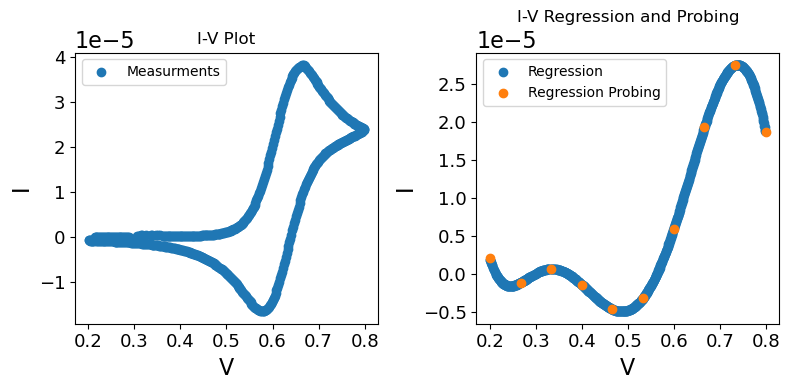

In [9]:
def v_vs_I_Plot(lst_plots,title=''):
    for indx in lst_plots:
        plt.scatter(indx[1],indx[0],label=indx[2])
        plt.xlabel('V', fontsize = 16)
        plt.ylabel('I', fontsize = 16)
        plt.yticks(fontsize = 13)
        plt.xticks(fontsize = 13)
        plt.gca().yaxis.offsetText.set_fontsize(16)
        plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
        plt.legend(loc='best')
        plt.tight_layout()
        plt.title(title)
            


plt.figure(figsize=(8,4))
#plt.suptitle(f' CV Measurement Analysis: {save_file_name}')
ax1 = plt.subplot(1, 2, 1)
v_vs_I_Plot([(I,Ewe,'Measurments')],title='I-V Plot')

#####################################
ax2=plt.subplot(1, 2, 2)
v_vs_I_Plot([(y_pred,Ewe,'Regression'),(i_probe_t,v_probe,'Regression Probing')],title='I-V Regression and Probing')


plt.show()

